In [ ]:
# install libraries for Google Colab
!pip install --upgrade tables
!pip install eli5
!pip install scikit-plot
!pip install xgboost
!pip install hyperopt

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [ ]:
# import libraries

import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit, train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

# import models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Optimization
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None


random_state=2020

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pand

## Load the data

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution'

/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution


In [ ]:
# load the wrangled and transformed data 
df = pd.read_hdf('data/warsaw_air_pollution_2015-2019_feature_eng.h5', key='df')

In [ ]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log,apparentTemperature_lag1h,cloudCover_lag1h,dewPoint_lag1h,humidity_lag1h,humidity_log_lag1h,precipIntensity_lag1h,precipProbability_lag1h,pressure_lag1h,temperature_lag1h,uvIndex_lag1h,visibility_lag1h,windBearing_lag1h,windSpeed_lag1h,windSpeed_log_lag1h,apparentTemperature_lag24h,cloudCover_lag24h,dewPoint_lag24h,humidity_lag24h,humidity_log_lag24h,precipIntensity_lag24h,precipProbability_lag24h,pressure_lag24h,temperature_lag24h,uvIndex_lag24h,visibility_lag24h,windBearing_lag24h,windSpeed_lag24h,windSpeed_log_lag24h,apparentTemperature_rolling12h,cloudCover_rolling12h,dewPoint_rolling12h,humidity_rolling12h,humidity_log_rolling12h,precipIntensity_rolling12h,precipProbability_rolling12h,pressure_rolling12h,temperature_rolling12h,uvIndex_rolling12h,visibility_rolling12h,windBearing_rolling12h,windSpeed_rolling12h,windSpeed_log_rolling12h,apparentTemperature_rolling24h,cloudCover_rolling24h,dewPoint_rolling24h,humidity_rolling24h,humidity_log_rolling24h,precipIntensity_rolling24h,precipProbability_rolling24h,pressure_rolling24h,temperature_rolling24h,uvIndex_rolling24h,visibility_rolling24h,windBearing_rolling24h,windSpeed_rolling24h,windSpeed_log_rolling24h,apparentTemperature_rolling72h,cloudCover_rolling72h,dewPoint_rolling72h,humidity_rolling72h,humidity_log_rolling72h,precipIntensity_rolling72h,precipProbability_rolling72h,pressure_rolling72h,temperature_rolling72h,uvIndex_rolling72h,visibility_rolling72h,windBearing_rolling72h,windSpeed_rolling72h,windSpeed_log_rolling72h,apparentTemperature_rolling168h,cloudCover_rolling168h,dewPoint_rolling168h,humidity_rolling168h,humidity_log_rolling168h,precipIntensity_rolling168h,precipProbability_rolling168h,pressure_rolling168h,temperature_rolling168h,uvIndex_rolling168h,visibility_rolling168h,windBearing_rolling168h,windSpeed_rolling168h,windSpeed_log_rolling168h,mean_apparentTemperature_per_day,mean_cloudCover_per_day,mean_dewPoint_per_day,mean_humidity_per_day,mean_humidity_log_per_day,mean_precipIntensity_per_day,mean_precipProbability_per_day,mean_pressure_per_day,mean_temperature_per_day,mean_uvIndex_per_day,mean_visibility_per_day,mean_windBearing_per_day,mean_windSpeed_per_day,mean_windSpeed_log_per_day,mean_PM25_nie_per_day,mean_PM25_wok_per_day,mean_PM25_nie_log_per_day,mean_PM25_wok_log_per_day,median_apparentTemperature_per_day,median_cloudCover_per_day,median_dewPoint_per_day,median_humidity_per_day,median_humidity_log_per_day,median_precipIntensity_per_day,median_precipProbability_per_day,median_pressure_per_day,median_temperature_per_day,median_uvIndex_per_day,median_visibility_per_day,median_windBearing_per_day,median_windSpeed_per_day,median_windSpeed_log_per_day,median_PM25_nie_per_day,median_PM25_wok_per_day,median_PM25_nie_log_per_day,median_PM25_wok_log_per_day,mean_apparentTemperature_per_month,mean_cloudCover_per_month,mean_dewPoint_per_month,mean_humidity_per_month,mean_humidity_log_per_month,mean_precipIntensity_per_month,mean_precipProbability_per_month,mean_pressure_per_month,mean_temperature_per_month,mean_uvIndex_per_month,mean_visibility_per_month,mean_windBearing_per_month,mean_windSpeed_per_month,mean_windSpeed_log_per_month,mean_PM25_nie_per_month,mean_PM25_wok_per_month,mean_PM25_nie_log_per_month,mean_PM25_wok_log_per_month,median_apparentTemperature_per_month,median_cloudCover_per_month,median_dewPoint_per_month,median_humidity_per_month,median_humidity_log_per_month,median_precipIntensity_per_month,median_precipProbability_per_month,median_pressure_per_month,median_temperature_per_month,median_uvIndex_per_month,median_visibility_per_month,median_windBearing_per_month,median_windSpeed_per_month,median_windSpeed_log_per_month,median_PM

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43848 entries, 0 to 43847
Data columns (total 228 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   datetime                                datetime64[ns]
 1   apparentTemperature                     float64       
 2   cloudCover                              float64       
 3   dewPoint                                float64       
 4   humidity                                float64       
 5   icon                                    object        
 6   precipIntensity                         float64       
 7   precipProbability                       float64       
 8   pressure                                float64       
 9   summary                                 object        
 10  temperature                             float64       
 11  uvIndex                                 float64       
 12  visibility                              float

#### Split the data for train and test

In [ ]:
# split the df for train and test, leave last 6 month for the test
train_mask = df['datetime'] < '2019-07-01'
test_mask = df['datetime'] >= '2019-07-01'

df_train = df.loc[train_mask]
df_test = df.loc[test_mask]

In [ ]:
# check if the train dataset is correctly split
df_train.datetime.min(), df_train.datetime.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2019-06-30 23:00:00'))

In [ ]:
# check if the test dataset is correctly split
df_test.datetime.min(), df_test.datetime.max()

(Timestamp('2019-07-01 00:00:00'), Timestamp('2019-12-31 23:00:00'))

## Create functions for quick iterations and scoring

In [ ]:
# function to run different models
def run_model(model, X, y, cross_val):
    model_name = type(model).__name__

    rmse = np.sqrt(-cross_val_score(model, X, y, cv=cross_val, scoring='neg_mean_squared_error'))
    r2 = cross_val_score(model, X, y, cv=cross_val, scoring='r2')
    print("{} RMSE: {:.4f}, r2: {:.1f}%".format(model_name, np.mean(rmse), 100*np.mean(r2)))

In [ ]:
# function to plot a learning curve for different models and scoring
def plot_lear_curve(model, X, y, cross_val, scoring, ax):

  model_name = type(model).__name__
  skplt.estimators.plot_learning_curve(model, X, y, cv=cross_val, scoring=scoring,
                                       title=f'{model_name} Learning Curve', ax=ax);

##Define cross-validation and initiate simple models for benchmarking purpose

In [ ]:
# define Cross Validation
tcsv = TimeSeriesSplit(n_splits=5)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

# define simple models for fast testing
Dummy_model = DummyRegressor(strategy="mean")
DT_model = DecisionTreeRegressor(max_depth=3, random_state=random_state)
RF_model = RandomForestRegressor(max_depth=3, random_state=random_state)
XGB_model = xgb.XGBRegressor(max_depth=3, objective='reg:squarederror', random_state=random_state)
LGBM_model = lgb.LGBMRegressor(max_depth=3, objective='regression', random_state=random_state)

# add all models to a list
models = [Dummy_model, DT_model, RF_model, XGB_model, LGBM_model]

###Run and evaluate models on original darksky.net features

In [ ]:
# select original features from darksky.net
orig_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity',
              'precipProbability', 'pressure', 'temperature', 'uvIndex',
              'visibility', 'windBearing', 'windSpeed', 'icon_num']

In [ ]:
# define X_train, y_train for original features
X_train = df_train[orig_feats].values
y_train = df_train['PM25_nie_log'].values

In [ ]:
# evaluate models on time series split
for model in models:
    run_model(model, X_train, y_train, tcsv)

DummyRegressor RMSE: 0.6046, r2: -8.8%
DecisionTreeRegressor RMSE: 0.4983, r2: 23.5%
RandomForestRegressor RMSE: 0.4819, r2: 28.6%
XGBRegressor RMSE: 0.4579, r2: 31.4%
LGBMRegressor RMSE: 0.4612, r2: 29.9%


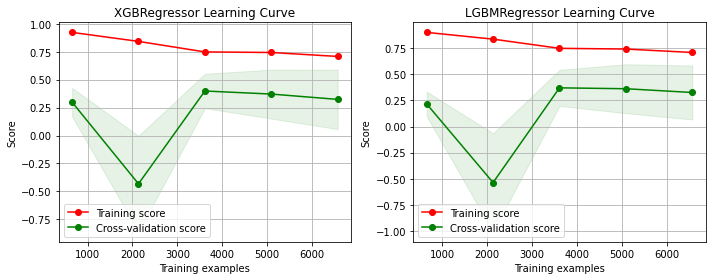

In [ ]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(10,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(model, X_train, y_train, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [ ]:
# evaluate models on KFold
for model in models:
    run_model(model, X_train, y_train, kf)

DummyRegressor RMSE: 0.6104, r2: -0.0%
DecisionTreeRegressor RMSE: 0.4769, r2: 39.0%
RandomForestRegressor RMSE: 0.4716, r2: 40.3%
XGBRegressor RMSE: 0.3975, r2: 57.6%
LGBMRegressor RMSE: 0.3972, r2: 57.7%


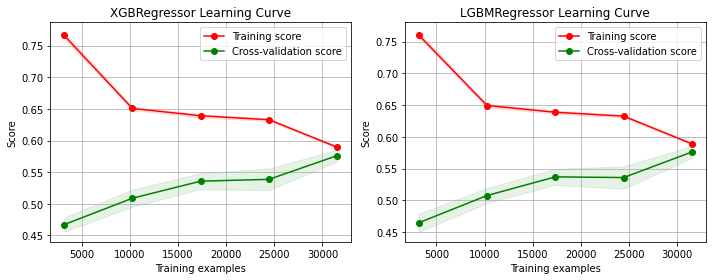

In [ ]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(10,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

###Fit models

In [ ]:
# fit models
Dummy_model.fit(X_train, y_train)
DT_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)

###Predict on test data

In [ ]:
# predict on all feats 
y_test_Dummy_orig = Dummy_model.predict(X_test)
y_test_DT_orig = DT_model.predict(X_test)
y_test_RF_orig = RF_model.predict(X_test)
y_test_XGB_orig = XGB_model.predict(X_test)
y_test_LGBM_orig = LGBM_model.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_dummy_orig'] = np.expm1(y_test_Dummy_orig)
df_test['PM25_nie_pred_DT_orig'] = np.expm1(y_test_DT_orig)
df_test['PM25_nie_pred_RF_orig'] = np.expm1(y_test_RF_orig)
df_test['PM25_nie_pred_XGB_orig'] = np.expm1(y_test_XGB_orig)
df_test['PM25_nie_pred_LGBM_orig'] = np.expm1(y_test_LGBM_orig)

In [ ]:
# check RMSE for test data on all feats
dummy_rmse_orig = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_dummy_orig']))
dt_rmse_orig = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_DT_orig']))
rf_rmse_orig = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_RF_orig']))
xgb_rmse_orig = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_XGB_orig']))
lgbm_rmse_orig = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_LGBM_orig']))

# check r2 for test data on all feats
dummy_r2_orig = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_dummy_orig'])
dt_r2_orig = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_DT_orig'])
rf_r2_orig = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_RF_orig'])
xgb_r2_orig = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_XGB_orig'])
lgbm_r2_orig = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_LGBM_orig'])

In [ ]:
print("-----RMSE and r2 results on the test data using original features-----")
print("Dummy Regressor: RMSE: {:.4f}, r2: {:.1f}%".format(dummy_rmse_orig, 100*np.mean(dummy_r2_orig)))
print("Decision Tree: RMSE: {:.4f}, r2: {:.1f}%".format(dt_rmse_orig, 100*np.mean(dt_r2_orig)))
print("Random Forest: RMSE: {:.4f}, r2: {:.1f}%".format(rf_rmse_orig, 100*np.mean(rf_r2_orig)))
print("XGBoost: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_orig, 100*np.mean(xgb_r2_orig)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_orig, 100*np.mean(lgbm_r2_orig)))

###Run and evaluate models on original and time based features

In [ ]:
# extend original features with new time based ones
time_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 'precipProbability',
              'pressure', 'temperature', 'uvIndex', 'visibility', 'windBearing', 'windSpeed',
              'icon_num', 'Autumn', 'Spring', 'Summer', 'Winter',
              'year', 'month', 'day', 'dayofyear', 'hour', 'weekday', 'IsWeekend']

# define X_train
X_train = df_train[time_feats].values

In [ ]:
# evaluate models on time series split
for model in models:
    run_model(model, X_train, y_train, tcsv)

DummyRegressor RMSE: 0.6046, r2: -8.8%
DecisionTreeRegressor RMSE: 0.5104, r2: 19.3%
RandomForestRegressor RMSE: 0.4925, r2: 25.1%
XGBRegressor RMSE: 0.3997, r2: 50.7%
LGBMRegressor RMSE: 0.3983, r2: 50.9%


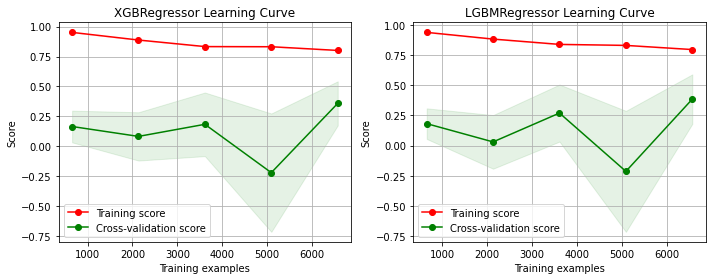

In [ ]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(10,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(model, X_train, y_train, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [ ]:
# evaluate models on KFold
for model in models:
    run_model(model, X_train, y_train, kf)

DummyRegressor RMSE: 0.6104, r2: -0.0%
DecisionTreeRegressor RMSE: 0.4706, r2: 40.5%
RandomForestRegressor RMSE: 0.4644, r2: 42.1%
XGBRegressor RMSE: 0.3504, r2: 67.0%
LGBMRegressor RMSE: 0.3499, r2: 67.1%


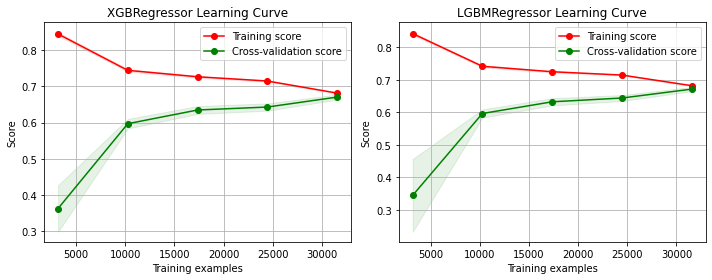

In [ ]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(10,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

### Fit models

In [ ]:
# fit models
Dummy_model.fit(X_train, y_train)
DT_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)

###Predict on test data

In [ ]:
# predict on all feats 
y_test_Dummy_time = Dummy_model.predict(X_test)
y_test_DT_time = DT_model.predict(X_test)
y_test_RF_time = RF_model.predict(X_test)
y_test_XGB_time = XGB_model.predict(X_test)
y_test_LGBM_time = LGBM_model.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_dummy_time'] = np.expm1(y_test_Dummy_time)
df_test['PM25_nie_pred_DT_time'] = np.expm1(y_test_DT_time)
df_test['PM25_nie_pred_RT_time'] = np.expm1(y_test_RF_time)
df_test['PM25_nie_pred_XGB_time'] = np.expm1(y_test_XGB_time)
df_test['PM25_nie_pred_LGBM_time'] = np.expm1(y_test_LGBM_time)

In [ ]:
# check RMSE for test data on all feats
dummy_rmse_time = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_dummy_time']))
dt_rmse_time = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_DT_time']))
rf_rmse_time = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_RF_time']))
xgb_rmse_time = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_XGB_time']))
lgbm_rmse_time = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_LGBM_time']))

# check r2 for test data on all feats
dummy_r2_time = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_dummy_time'])
dt_r2_time = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_DT_time'])
rf_r2_time = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_RF_time'])
xgb_r2_time = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_XGB_time'])
lgbm_r2_time = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_LGBM_time'])

In [ ]:
print("-----RMSE and r2 results on the test data using original and time-based features-----")
print("Dummy Regressor: RMSE: {:.4f}, r2: {:.1f}%".format(dummy_rmse_time, 100*np.mean(dummy_r2_time)))
print("Decision Tree: RMSE: {:.4f}, r2: {:.1f}%".format(dt_rmse_time, 100*np.mean(dt_r2_time)))
print("Random Forest: RMSE: {:.4f}, r2: {:.1f}%".format(rf_rmse_time, 100*np.mean(rf_r2_time)))
print("XGBoost: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_time, 100*np.mean(xgb_r2_time)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_time, 100*np.mean(lgbm_r2_time)))

###Run models on all features except features realted to PM2.5

In [ ]:
# function to get all numerical features, except the one related to PM2.5 and Wokalna Street measures
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = [
                  # Niepodleglosci
                  'PM25_nie', 'PM25_nie_log', 'PM25_nie_mean', 'mean_PM25_nie_per_day',
                  'mean_PM25_nie_log_per_day', 'median_PM25_nie_per_day', 'median_PM25_nie_log_per_day',
                  'mean_PM25_nie_per_month', 'mean_PM25_nie_log_per_month', 'median_PM25_nie_per_month',
                  'median_PM25_nie_log_per_month',
                  # Wokalna
                  'PM25_wok', 'PM25_wok_log', 'PM25_wok_mean', 'mean_PM25_wok_per_day', 
                  'mean_PM25_wok_log_per_day', 'median_PM25_wok_per_day', 'median_PM25_wok_log_per_day',
                  'mean_PM25_wok_per_month', 'mean_PM25_wok_log_per_month', 'median_PM25_wok_per_month',
                  'median_PM25_wok_log_per_month',
                  # features increasing RMSE and decreasing r2 results
                  'temperature_12-24h_ma_diff', 'apparentTemperature_12-24h_ma_diff', 'dewPoint_12-24h_ma_diff',
                  'humidity_12-24h_ma_diff', 'windSpeed_12-24h_ma_diff', 'windBearing_12-24h_ma_diff',
                  'isHumidWorkingDay', 'isColdWorkingDay', 'isWindlessWorkingDay', 'isWindlessColdHumidWorkingDay',
                  'NonWorkingHoursInWeek', 'NonWorkingHumidHoursInWeek', 'NonWorkingColdHoursInWeek',	
                  'NonWorkingWindlessHoursInWeek', 'NonWorkingWindlessColdHumidHoursInWeek'
                  ]
                  
    return [x for x in feats if x not in black_list]

In [ ]:
#get feats
feats = get_feats(df_train)

# define X_train
X_train = df_train[feats].values

In [ ]:
# evaluate models on time series split
for model in models[1:]:
    run_model(model, X_train, y_train, tcsv)

DecisionTreeRegressor RMSE: 0.5067, r2: 20.0%
RandomForestRegressor RMSE: 0.4669, r2: 32.3%
XGBRegressor RMSE: 0.3640, r2: 58.7%
LGBMRegressor RMSE: 0.3656, r2: 58.4%


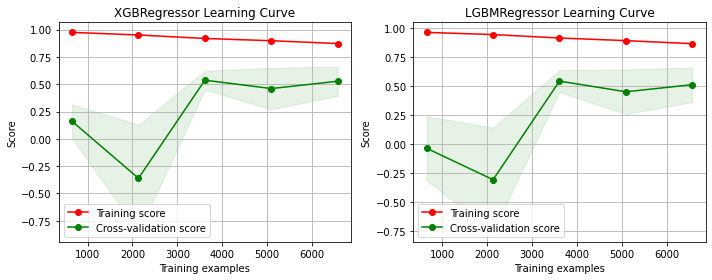

In [ ]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(10,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(model, X_train, y_train, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [ ]:
# evaluate models on KFold
for model in models[1:]:
    run_model(model, X_train, y_train, kf)

DecisionTreeRegressor RMSE: 0.4373, r2: 48.7%
RandomForestRegressor RMSE: 0.4264, r2: 51.2%
XGBRegressor RMSE: 0.3012, r2: 75.6%
LGBMRegressor RMSE: 0.3013, r2: 75.6%


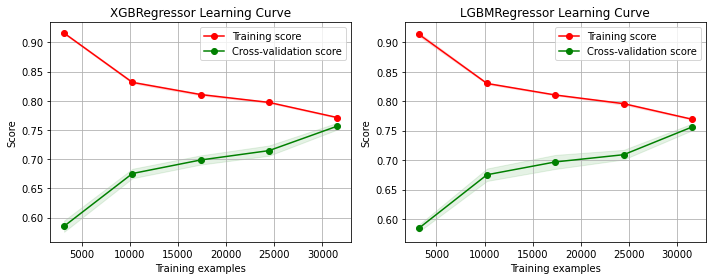

In [ ]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(10,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

##Parameters tuning with HyperOpt on all features except features realted to PM2.5

In [ ]:
# define X_train, y_train
X_train = df_train[feats].values
y_train = df_train['PM25_nie_log'].values

# define X_test, y_test
X_test = df_test[feats].values
y_test = df_test['PM25_nie_log'].values

###Define XGBoost and Light GBM HyperOpt functions

In [ ]:
# define hyperopt function for XGBoost
def run_xgb_hyperopt(X, y, tree_method, grow_policy, cv, max_evals):

    def objective(space):
        XGB_model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                              max_depth = int(space['max_depth']),
                              min_child_weight = space['min_child_weight'],
                              subsample = space['subsample'],
                              learning_rate = space['learning_rate'],
                              gamma = space['gamma'],
                              colsample_bytree = space['colsample_bytree'],
                              objective='reg:squarederror',
                              tree_method=tree_method,
                              grow_policy=grow_policy,
                              random_state=random_state
                              )
        
        for train_idx, test_idx in cv.split(X):

            eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
            XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
            y_pred = XGB_model.predict(X[test_idx])

            rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
            r2 = r2_score(y[test_idx], y_pred)
            
            print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
            return{'loss': rmse, 'status': STATUS_OK }
        
        
    space ={
            'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hp.uniform('subsample', 0.7, 1),
            'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
            'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
            'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }

    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=partial(tpe.suggest, n_startup_jobs=1),
                max_evals=max_evals,
                trials=trials)

    print("The best params: ", best)
    return best

In [ ]:
# define hyperopt function for Light GBM
def run_lgbm_hyperopt(X, y, cv, max_evals):

    def objective(space):
        LGBM_model = lgb.LGBMRegressor(
                    max_depth = int(space['max_depth']),
                    n_estimators = space['n_estimators'],
                    num_leaves = space['num_leaves'],
                    min_child_weight = space['min_child_weight'],
                    subsample = space['subsample'],
                    learning_rate = space['learning_rate'],
                    gamma = space['gamma'],
                    colsample_bytree = space['colsample_bytree'],
                    objective='regression',
                    random_state=random_state
                    )
        
        for train_idx, test_idx in cv.split(X):

            eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
            LGBM_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
            y_pred = LGBM_model.predict(X[test_idx])

            rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
            r2 = r2_score(y[test_idx], y_pred)
            
            print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
            return{'loss': rmse, 'status': STATUS_OK }
        
        
    space ={
            'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
            'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
            'num_leaves' : hp.choice('num_leaves', np.arange(10, 30, 1, dtype=int)),
            'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
            'subsample': hp.uniform('subsample', 0.7, 1),
            'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
            'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
            }

    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=partial(tpe.suggest, n_startup_jobs=1),
                max_evals=max_evals,
                trials=trials)

    print("The best params: ", best)
    return best

###Run and fit models

In [ ]:
# run model with grow_policy='depthwise'
best = run_xgb_hyperopt(X_train, y_train, tree_method='hist', grow_policy='depthwise', cv=kf, max_evals=10)

RMSE: 0.2011, r2: 89.2%
RMSE: 0.2117, r2: 88.0%
RMSE: 0.2246, r2: 86.5%
RMSE: 0.2485, r2: 83.5%
RMSE: 0.2005, r2: 89.3%
RMSE: 0.2252, r2: 86.5%
RMSE: 0.2223, r2: 86.8%
RMSE: 0.2508, r2: 83.2%
RMSE: 0.2574, r2: 82.3%
RMSE: 0.2242, r2: 86.6%
100%|██████████| 10/10 [04:00<00:00, 24.05s/it, best loss: 0.20049842661435696]
The best params:  {'colsample_bytree': 0.75, 'gamma': 0.65, 'learning_rate': 0.30000000000000004, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 223, 'subsample': 0.7788030498227181}


In [ ]:
# initite model with best parameters
XGB_model_depth = xgb.XGBRegressor(**best, objective='reg:squarederror', tree_method='hist', grow_policy='depthwise', random_state=random_state)
XGB_model_depth.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75, gamma=0.65,
             grow_policy='depthwise', importance_type='gain',
             learning_rate=0.30000000000000004, max_delta_step=0, max_depth=3,
             min_child_weight=6.0, missing=None, n_estimators=223, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7788030498227181, tree_method='hist',
             verbosity=1)

In [ ]:
# check perutation importance with eli5
perm = PermutationImportance(XGB_model_depth).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.0700 ± 0.0013,mean_apparentTemperature_per_month
0.0542 ± 0.0022,dewPoint_rolling168h
0.0512 ± 0.0016,windSpeed_rolling12h
0.0309 ± 0.0010,visibility
0.0293 ± 0.0005,pressure_rolling24h
0.0278 ± 0.0013,windSpeed_rolling24h
0.0260 ± 0.0007,windSpeed_lag1h
0.0258 ± 0.0007,median_apparentTemperature_per_day
0.0248 ± 0.0006,dewPoint
0.0205 ± 0.0007,hour


In [ ]:
# run model with grow_policy='lossguide'
best = run_xgb_hyperopt(X_train, y_train, tree_method='hist', grow_policy='lossguide', cv=kf, max_evals=10)

RMSE: 0.2825, r2: 78.7%
RMSE: 0.2958, r2: 76.7%
RMSE: 0.2363, r2: 85.1%
RMSE: 0.2356, r2: 85.2%
RMSE: 0.2308, r2: 85.8%
RMSE: 0.2197, r2: 87.1%
RMSE: 0.2069, r2: 88.6%
RMSE: 0.2029, r2: 89.0%
RMSE: 0.2054, r2: 88.7%
RMSE: 0.2063, r2: 88.6%
100%|██████████| 10/10 [05:23<00:00, 32.36s/it, best loss: 0.2029331951145029]
The best params:  {'colsample_bytree': 0.65, 'gamma': 0.8, 'learning_rate': 0.30000000000000004, 'max_depth': 4, 'min_child_weight': 5.0, 'n_estimators': 192, 'subsample': 0.8785959876136616}


In [ ]:
# initite model with best parameters
XGB_model_leaf = xgb.XGBRegressor(**best, objective='reg:squarederror', tree_method='hist', grow_policy='lossguide', random_state=random_state)
XGB_model_leaf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.65, gamma=0.8,
             grow_policy='lossguide', importance_type='gain',
             learning_rate=0.30000000000000004, max_delta_step=0, max_depth=4,
             min_child_weight=5.0, missing=None, n_estimators=192, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8785959876136616, tree_method='hist',
             verbosity=1)

In [ ]:
# check perutation importance with eli5
perm = PermutationImportance(XGB_model_leaf).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.1593 ± 0.0024,mean_apparentTemperature_per_month
0.0487 ± 0.0007,windSpeed_rolling12h
0.0421 ± 0.0020,windSpeed_rolling24h
0.0298 ± 0.0003,dewPoint_rolling168h
0.0291 ± 0.0005,dewPoint
0.0245 ± 0.0002,hour
0.0216 ± 0.0004,windSpeed_lag1h
0.0176 ± 0.0004,year
0.0175 ± 0.0006,visibility
0.0172 ± 0.0006,visibility_lag1h


In [ ]:
# run Light GBM model
best = run_lgbm_hyperopt(X_train, y_train, cv=kf, max_evals=10)

RMSE: 0.2046, r2: 88.8%
RMSE: 0.2039, r2: 88.9%
RMSE: 0.3099, r2: 74.4%
RMSE: 0.2961, r2: 76.6%
RMSE: 0.2357, r2: 85.2%
RMSE: 0.1803, r2: 91.3%
RMSE: 0.1879, r2: 90.6%
RMSE: 0.2066, r2: 88.6%
RMSE: 0.1885, r2: 90.5%
RMSE: 0.1822, r2: 91.1%
100%|██████████| 10/10 [01:40<00:00, 10.09s/it, best loss: 0.18034262954166638]
The best params:  {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.30000000000000004, 'max_depth': 2, 'min_child_weight': 6.0, 'n_estimators': 225, 'num_leaves': 13, 'subsample': 0.9940633656831415}


In [ ]:
# initite model with best parameters
LGBM_model = lgb.LGBMRegressor(**best, objective='regression', random_state=random_state)
LGBM_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              gamma=0.5, importance_type='split',
              learning_rate=0.30000000000000004, max_depth=2,
              min_child_samples=20, min_child_weight=6.0, min_split_gain=0.0,
              n_estimators=225, n_jobs=-1, num_leaves=13,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.9940633656831415,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# check perutation importance with eli5
perm = PermutationImportance(LGBM_model).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.0535 ± 0.0007,median_apparentTemperature_per_month
0.0306 ± 0.0017,windSpeed_rolling12h
0.0272 ± 0.0011,windSpeed_rolling24h
0.0267 ± 0.0014,visibility
0.0266 ± 0.0013,dewPoint_rolling168h
0.0229 ± 0.0006,dewPoint
0.0202 ± 0.0006,windSpeed_diff_for_month_mean
0.0201 ± 0.0010,windSpeed_lag1h
0.0198 ± 0.0005,humidity
0.0193 ± 0.0009,year


###Evaluate models

In [ ]:
# evaluate models on KFold
models = [XGB_model_depth, XGB_model_leaf, LGBM_model]

for model in models:
    run_model(model, X_train, y_train, kf)

XGBRegressor RMSE: 0.2361, r2: 85.0%
XGBRegressor RMSE: 0.2189, r2: 87.1%
LGBMRegressor RMSE: 0.2744, r2: 79.8%


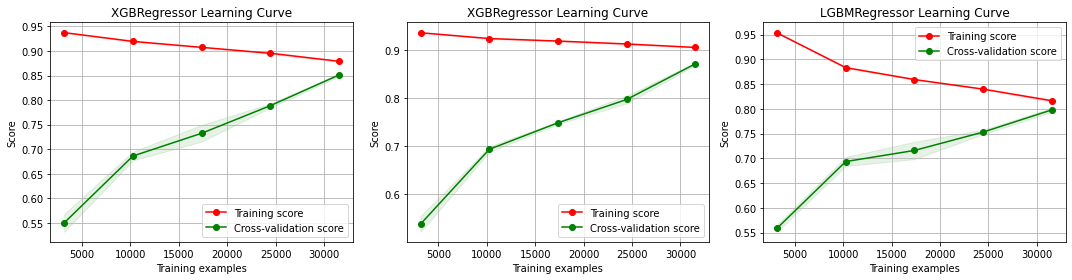

In [ ]:
fig=plt.figure(figsize=(15,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

###Predict on test data

In [ ]:
# predict on all feats 
y_test_XGB_depth = XGB_model_depth.predict(X_test)
y_test_XGB_leaf = XGB_model_leaf.predict(X_test)
y_test_LGBM = LGBM_model.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_xgb_depth'] = np.expm1(y_test_XGB_depth)
df_test['PM25_nie_pred_xgb_leaf'] = np.expm1(y_test_XGB_leaf)
df_test['PM25_nie_pred_lgbm'] = np.expm1(y_test_LGBM)

In [ ]:
# check RMSE for test data on all feats
xgb_rmse_depth = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth']))
xgb_rmse_leaf = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf']))
lgbm_rmse = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm']))

# check r2 for test data on all feats
xgb_r2_depth = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth'])
xgb_r2_leaf = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf'])
lgbm_r2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm'])

In [ ]:
print("-----RMSE and r2 results on the test data using all features-----")
print("XGBoost_Depth: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth, 100*np.mean(xgb_r2_depth)))
print("XGBoost_Leaf: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf, 100*np.mean(xgb_r2_leaf)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse, 100*np.mean(lgbm_r2)))

-----RMSE and r2 results on the test data using all features-----
XGBoost_Depth: RMSE: 8.6377, r2: 31.8%
XGBoost_Leaf: RMSE: 8.2202, r2: 38.3%
LightGBM: RMSE: 7.5505, r2: 47.9%


##Parameters tuning with HyperOpt on selected features

###Feature Selection: Recursive Feature Elimination (RFE)

In [ ]:
# define RFE for each model
models = {'XGB_depth':XGB_model_depth, 'XGB_leaf':XGB_model_leaf, 'LGBM':LGBM_model}

for i, model in models.items():
  globals()['sel_{}'.format(i)] = RFE(model, step=0.8, n_features_to_select=25, verbose=True)

In [ ]:
# fit RFE to the data and then transform it
eliminators = {'XGB_depth':sel_XGB_depth, 'XGB_leaf':sel_XGB_leaf, 'LGBM':sel_LGBM}

for i, eliminator in eliminators.items():
  globals()['X_train_reduced_{}'.format(i)] = eliminator.fit_transform(X_train, y_train)

Fitting estimator with 188 features.
Fitting estimator with 38 features.
Fitting estimator with 188 features.
Fitting estimator with 38 features.
Fitting estimator with 188 features.
Fitting estimator with 38 features.


In [ ]:
# transform X_test so it corresponds to X_train features
for i, eliminator in eliminators.items():
  globals()['X_test_reduced_{}'.format(i)] = eliminator.transform(X_test)

In [ ]:
XGB_depth_feats = ~sel_XGB_depth.get_support() == False

In [ ]:
XGB_leaf_feats = ~sel_XGB_leaf.get_support() == False

In [ ]:
LGBM_feats = ~sel_LGBM.get_support() == False

####Run models

In [ ]:
# run hyperopt for XGBoost model with grow_policy='depthwise' and return best results
best_XGB_depth = run_xgb_hyperopt(X_train_reduced_XGB_depth, y_train, tree_method='hist', grow_policy='depthwise', cv=kf, max_evals=10)

RMSE: 0.3409, r2: 69.0%
RMSE: 0.2915, r2: 77.3%
RMSE: 0.3344, r2: 70.2%
RMSE: 0.2451, r2: 84.0%
RMSE: 0.2425, r2: 84.3%
RMSE: 0.2490, r2: 83.4%
RMSE: 0.2663, r2: 81.1%
RMSE: 0.2362, r2: 85.1%
RMSE: 0.2617, r2: 81.7%
RMSE: 0.2351, r2: 85.2%
100%|██████████| 10/10 [01:00<00:00,  6.06s/it, best loss: 0.23514750005937243]
The best params:  {'colsample_bytree': 0.8500000000000001, 'gamma': 0.7000000000000001, 'learning_rate': 0.225, 'max_depth': 3, 'min_child_weight': 9.0, 'n_estimators': 115, 'subsample': 0.7799309339241063}


In [ ]:
# run hyperopt for XGBoost model with grow_policy='lossguide' and return best results
best_XGB_leaf = run_xgb_hyperopt(X_train_reduced_XGB_leaf, y_train, tree_method='hist', grow_policy='lossguide', cv=kf, max_evals=10)

RMSE: 0.2373, r2: 85.0%
RMSE: 0.2451, r2: 84.0%
RMSE: 0.2259, r2: 86.4%
RMSE: 0.2888, r2: 77.7%
RMSE: 0.2918, r2: 77.3%
RMSE: 0.2499, r2: 83.3%
RMSE: 0.3168, r2: 73.2%
RMSE: 0.2425, r2: 84.3%
RMSE: 0.2415, r2: 84.4%
RMSE: 0.2939, r2: 77.0%
100%|██████████| 10/10 [00:49<00:00,  4.95s/it, best loss: 0.22594922509395968]
The best params:  {'colsample_bytree': 0.65, 'gamma': 0.55, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'min_child_weight': 1.0, 'n_estimators': 84, 'subsample': 0.7808543018026219}


In [ ]:
# run hyperopt for Light GBM model and return best results
best_LGBM = run_lgbm_hyperopt(X_train_reduced_LGBM, y_train, cv=kf, max_evals=10)

RMSE: 0.2169, r2: 87.4%
RMSE: 0.2127, r2: 87.9%
RMSE: 0.2205, r2: 87.0%
RMSE: 0.2030, r2: 89.0%
RMSE: 0.2687, r2: 80.7%
RMSE: 0.1931, r2: 90.1%
RMSE: 0.1906, r2: 90.3%
RMSE: 0.1856, r2: 90.8%
RMSE: 0.2730, r2: 80.1%
RMSE: 0.2297, r2: 85.9%
100%|██████████| 10/10 [00:21<00:00,  2.10s/it, best loss: 0.18555757753410052]
The best params:  {'colsample_bytree': 0.75, 'gamma': 0.75, 'learning_rate': 0.375, 'max_depth': 5, 'min_child_weight': 7.0, 'n_estimators': 238, 'num_leaves': 6, 'subsample': 0.7988429910778517}


In [ ]:
# initiate models with best params
XGB_depth_rfe = xgb.XGBRegressor(**best_XGB_depth, objective='reg:squarederror', tree_method='hist', grow_policy='depthwise', random_state=random_state)
XGB_leaf_rfe = xgb.XGBRegressor(**best_XGB_leaf, objective='reg:squarederror', tree_method='hist', grow_policy='lossguide', random_state=random_state)
LGBM_rfe = lgb.LGBMRegressor(**best_LGBM, objective='regression', random_state=random_state)

####Evaluate models

In [ ]:
# check RMSE and r2 for a specific model and set of features
run_model(XGB_depth_rfe, X_train_reduced_XGB_depth, y, kf)

In [ ]:
# check RMSE and r2 for a specific model and set of features
run_model(XGB_leaf_rfe, X_train_reduced_XGB_leaf, y, kf)

In [ ]:
# check RMSE and r2 for a specific model and set of features
run_model(LGBM_rfe, X_train_reduced_LGBM, y, kf)

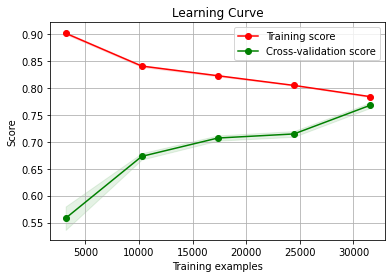

In [ ]:
# check the r2 learning curve a specific model and set of features
skplt.estimators.plot_learning_curve(XGB_depth_rfe, X_train_reduced_XGB_depth, y_train, cv=kf, scoring='r2');

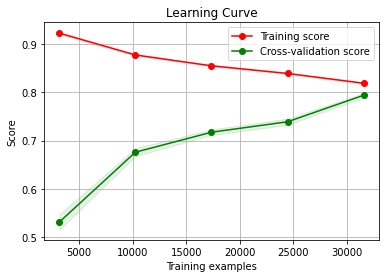

In [ ]:
# check the r2 learning curve a specific model and set of features
skplt.estimators.plot_learning_curve(XGB_leaf_rfe, X_train_reduced_XGB_leaf, y_train, cv=kf, scoring='r2');

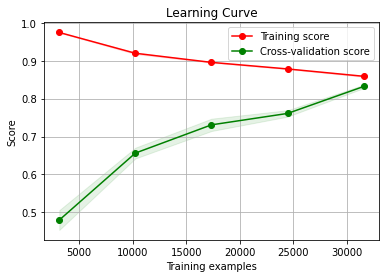

In [ ]:
# check the r2 learning curve a specific model and set of features
skplt.estimators.plot_learning_curve(LGBM_rfe, X_train_reduced_LGBM, y_train, cv=kf, scoring='r2');

####Fit models

In [ ]:
# fit models
XGB_depth_rfe.fit(X_train_reduced_XGB_depth, y_train)
XGB_leaf_rfe.fit(X_train_reduced_XGB_leaf, y_train)
LGBM_rfe.fit(X_train_reduced_LGBM, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
              gamma=0.75, importance_type='split', learning_rate=0.375,
              max_depth=5, min_child_samples=20, min_child_weight=7.0,
              min_split_gain=0.0, n_estimators=238, n_jobs=-1, num_leaves=6,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.7988429910778517,
              subsample_for_bin=200000, subsample_freq=0)

####Predict on test data

In [ ]:
# predict y
y_test_XGB_depth_rfe = XGB_depth_rfe.predict(X_test_reduced_XGB_depth)
y_test_XGB_leaf_rfe = XGB_leaf_rfe.predict(X_test_reduced_XGB_leaf)
y_test_XGB_rfe = LGBM_rfe.predict(X_test_reduced_LGBM)

In [ ]:
# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_xgb_depth_rfe'] = np.expm1(y_test_XGB_depth_rfe)
df_test['PM25_nie_pred_xgb_leaf_rfe'] = np.expm1(y_test_XGB_leaf_rfe)
df_test['PM25_nie_pred_lgbm_rfe'] = np.expm1(y_test_XGB_rfe)

In [ ]:
# check RMSE for features selected by RFE
xgb_rmse_depth_rfe = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_rfe']))
xgb_rmse_leaf_rfe = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_rfe']))
lgbm_rmse_rfe = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_rfe']))

# check r2 for features selected by RFE
xgb_r2_depth_rfe = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_rfe'])
xgb_r2_leaf_rfe = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_rfe'])
lgbm_r2_rfe = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_rfe'])

In [ ]:
print("-----RMSE and r2 results on the test data using features selected by RFE-----")
print("XGBoost_Depth: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth_rfe, 100*np.mean(xgb_r2_depth_rfe)))
print("XGBoost_Leaf: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf_rfe, 100*np.mean(xgb_r2_leaf_rfe)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_rfe, 100*np.mean(lgbm_r2_rfe)))

-----RMSE and r2 results on the test data using features selected by RFE-----
XGBoost_Depth: RMSE: 7.4222, r2: 49.7%
XGBoost_Leaf: RMSE: 7.2512, r2: 52.0%
LightGBM: RMSE: 9.0956, r2: 24.4%


###Feature Selection: Manual selection

In [ ]:
# list of manually selected features ### best performing so far ###
selected_feats = ['year',
                  'dayofyear',
                  'weekday',
                  'hour',
                  'visibility',
                  'humidity',
                  'apparentTemperature',
                  'mean_apparentTemperature_per_month',
                  'temperature',
                  'mean_temperature_per_month',
                  'dewPoint',
                  'dewPoint_rolling168h',
                  'windSpeed_lag1h',
                  'windSpeed_rolling12h',
                  'windSpeed_rolling24h',
                  'windBearing_lag1h',
                  'windBearing_rolling72h',
                  'uvIndex_rolling168h',
                  'temperature_24-72h_ma_diff',
                  'windSpeed_24-72h_ma_diff',
                  'windBearing_24-72h_ma_diff',
                  'humidity_24-72h_ma_diff'
                  ]

In [ ]:
# define X_train, y_train
X_train = df_train[selected_feats].values
y_train = df_train['PM25_nie_log'].values

# define X_test, y_test
X_test = df_test[selected_feats].values
y_test = df_test['PM25_nie_log'].values

####Run models

In [ ]:
# run hyperopt for XGBoost model with grow_policy='depthwise' and return best results
best_XGB_depth = run_xgb_hyperopt(X_train, y_train, tree_method='hist', grow_policy='depthwise', cv=kf, max_evals=10)

RMSE: 0.2844, r2: 78.4%
RMSE: 0.2161, r2: 87.5%
RMSE: 0.2610, r2: 81.8%
RMSE: 0.2260, r2: 86.4%
RMSE: 0.2817, r2: 78.8%
RMSE: 0.2275, r2: 86.2%
RMSE: 0.2495, r2: 83.4%
RMSE: 0.2474, r2: 83.7%
RMSE: 0.2206, r2: 87.0%
RMSE: 0.2907, r2: 77.5%
100%|██████████| 10/10 [01:14<00:00,  7.42s/it, best loss: 0.21607042076232363]
The best params:  {'colsample_bytree': 0.55, 'gamma': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3.0, 'n_estimators': 192, 'subsample': 0.845767043892219}


In [ ]:
# run hyperopt for XGBoost model with grow_policy='lossguide' and return best results
best_XGB_leaf = run_xgb_hyperopt(X_train, y_train, tree_method='hist', grow_policy='lossguide', cv=kf, max_evals=10)

RMSE: 0.2229, r2: 86.7%
RMSE: 0.2234, r2: 86.7%
RMSE: 0.2846, r2: 78.4%
RMSE: 0.2232, r2: 86.7%
RMSE: 0.3330, r2: 70.4%
RMSE: 0.2562, r2: 82.5%
RMSE: 0.4691, r2: 41.3%
RMSE: 0.2207, r2: 87.0%
RMSE: 0.2439, r2: 84.1%
RMSE: 0.2449, r2: 84.0%
100%|██████████| 10/10 [00:34<00:00,  3.41s/it, best loss: 0.22070845996951236]
The best params:  {'colsample_bytree': 0.5, 'gamma': 0.6000000000000001, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 8.0, 'n_estimators': 135, 'subsample': 0.7953765570070472}


In [ ]:
# run hyperopt for Light GBM model and return best results
best_LGBM = run_lgbm_hyperopt(X_train, y_train, cv=kf, max_evals=10)

RMSE: 0.2847, r2: 78.4%
RMSE: 0.2892, r2: 77.7%
RMSE: 0.3516, r2: 67.0%
RMSE: 0.2970, r2: 76.5%
RMSE: 0.3038, r2: 75.4%
RMSE: 0.1890, r2: 90.5%
RMSE: 0.2331, r2: 85.5%
RMSE: 0.2857, r2: 78.2%
RMSE: 0.3140, r2: 73.7%
RMSE: 0.2397, r2: 84.7%
100%|██████████| 10/10 [00:11<00:00,  1.19s/it, best loss: 0.18899485518793788]
The best params:  {'colsample_bytree': 0.6000000000000001, 'gamma': 0.9500000000000001, 'learning_rate': 0.25, 'max_depth': 4, 'min_child_weight': 1.0, 'n_estimators': 223, 'num_leaves': 14, 'subsample': 0.8777294217209284}


In [ ]:
# initiate models with best params
XGB_depth_manual = xgb.XGBRegressor(**best_XGB_depth, objective='reg:squarederror', tree_method='hist', grow_policy='depthwise', random_state=random_state)
XGB_leaf_manual = xgb.XGBRegressor(**best_XGB_leaf, objective='reg:squarederror', tree_method='hist', grow_policy='lossguide', random_state=random_state)
LGBM_manual = lgb.LGBMRegressor(**best_LGBM, objective='regression', random_state=random_state)

####Evaluate models

In [ ]:
# evaluate models on KFold
models = [XGB_depth_manual, XGB_leaf_manual, LGBM_manual]

for model in models:
    run_model(model, X_train, y_train, kf)

XGBRegressor RMSE: 0.2552, r2: 82.5%
XGBRegressor RMSE: 0.2971, r2: 76.3%
LGBMRegressor RMSE: 0.2443, r2: 84.0%


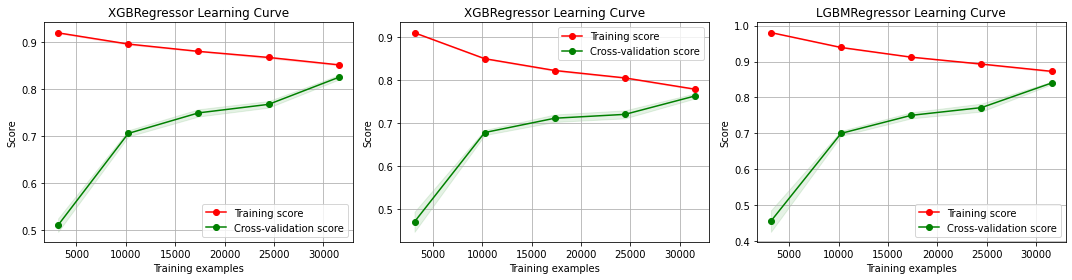

In [ ]:
fig=plt.figure(figsize=(15,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

####Fit models

In [ ]:
# fit models
XGB_depth_manual.fit(X_train, y_train)
XGB_leaf_manual.fit(X_train, y_train)
LGBM_manual.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6000000000000001, gamma=0.9500000000000001,
              importance_type='split', learning_rate=0.25, max_depth=4,
              min_child_samples=20, min_child_weight=1.0, min_split_gain=0.0,
              n_estimators=223, n_jobs=-1, num_leaves=14,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.8777294217209284,
              subsample_for_bin=200000, subsample_freq=0)

#### Predict on test data

In [ ]:
# predict on all feats 
y_test_XGB_depth_manual = XGB_depth_manual.predict(X_test)
y_test_XGB_leaf_manual = XGB_leaf_manual.predict(X_test)
y_test_LGBM_manual = LGBM_manual.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_xgb_depth_manual'] = np.expm1(y_test_XGB_depth_manual)
df_test['PM25_nie_pred_xgb_leaf_manual'] = np.expm1(y_test_XGB_leaf_manual)
df_test['PM25_nie_pred_lgbm_manual'] = np.expm1(y_test_LGBM_manual)

In [ ]:
# check RMSE for manually selected features
xgb_rmse_depth_manual = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_manual']))
xgb_rmse_leaf_manual = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_manual']))
lgbm_rmse_manual = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_manual']))

# check r2 for manually selected features
xgb_r2_depth_manual = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_manual'])
xgb_r2_leaf_manual = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_manual'])
lgbm_r2_manual = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_manual'])

In [ ]:
print("-----RMSE and r2 results on the test data using manually selected features-----")
print("XGBoost_Depth_v2: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth_manual, 100*np.mean(xgb_r2_depth_manual)))
print("XGBoost_Leaf_v2: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf_manual, 100*np.mean(xgb_r2_leaf_manual)))
print("LightGBM_v2: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_manual, 100*np.mean(lgbm_r2_manual)))

-----RMSE and r2 results on the test data using manually selected features-----
XGBoost_Depth_v2: RMSE: 6.8819, r2: 56.7%
XGBoost_Leaf_v2: RMSE: 6.8925, r2: 56.6%
LightGBM_v2: RMSE: 7.1887, r2: 52.8%


##Compare results

In [ ]:
print("-----RMSE and r2 results on the test data using all features-----")
print("XGBoost_Depth: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth, 100*np.mean(xgb_r2_depth)))
print("XGBoost_Leaf: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf, 100*np.mean(xgb_r2_leaf)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse, 100*np.mean(lgbm_r2)))
print(" ")
print("-----RMSE and r2 results on the test data using features selected by RFE-----")
print("XGBoost_Depth_RFE: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth_rfe, 100*np.mean(xgb_r2_depth_rfe)))
print("XGBoost_Leaf_RFE: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf_rfe, 100*np.mean(xgb_r2_leaf_rfe)))
print("LightGBM_RFE: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_rfe, 100*np.mean(lgbm_r2_rfe)))
print(" ")
print("-----RMSE and r2 results on the test data using manually selected features-----")
print("XGBoost_Depth_manual: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth_manual, 100*np.mean(xgb_r2_depth_manual)))
print("XGBoost_Leaf_manual: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf_manual, 100*np.mean(xgb_r2_leaf_manual)))
print("LightGBM_manual: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_manual, 100*np.mean(lgbm_r2_manual)))

-----RMSE and r2 results on the test data using all features-----
XGBoost_Depth: RMSE: 8.6377, r2: 31.8%
XGBoost_Leaf: RMSE: 8.2202, r2: 38.3%
LightGBM: RMSE: 7.5505, r2: 47.9%
 
-----RMSE and r2 results on the test data using features selected by RFE-----
XGBoost_Depth_RFE: RMSE: 7.4222, r2: 49.7%
XGBoost_Leaf_RFE: RMSE: 7.2512, r2: 52.0%
LightGBM_RFE: RMSE: 9.0956, r2: 24.4%
 
-----RMSE and r2 results on the test data using manually selected features-----
XGBoost_Depth_manual: RMSE: 6.8819, r2: 56.7%
XGBoost_Leaf_manual: RMSE: 6.8925, r2: 56.6%
LightGBM_manual: RMSE: 7.1887, r2: 52.8%


In [ ]:
# create a list of months in the test dataset
months = df_test.month.unique().tolist()
months

[7, 8, 9, 10, 11, 12]

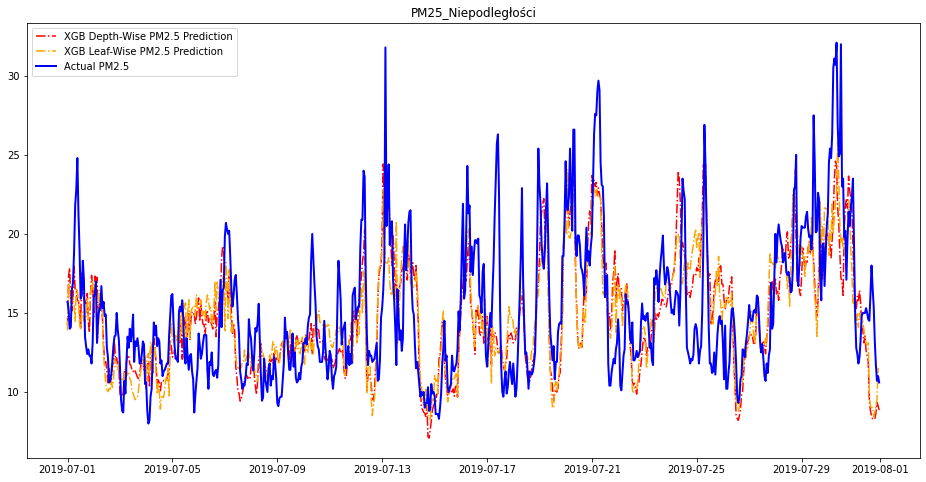

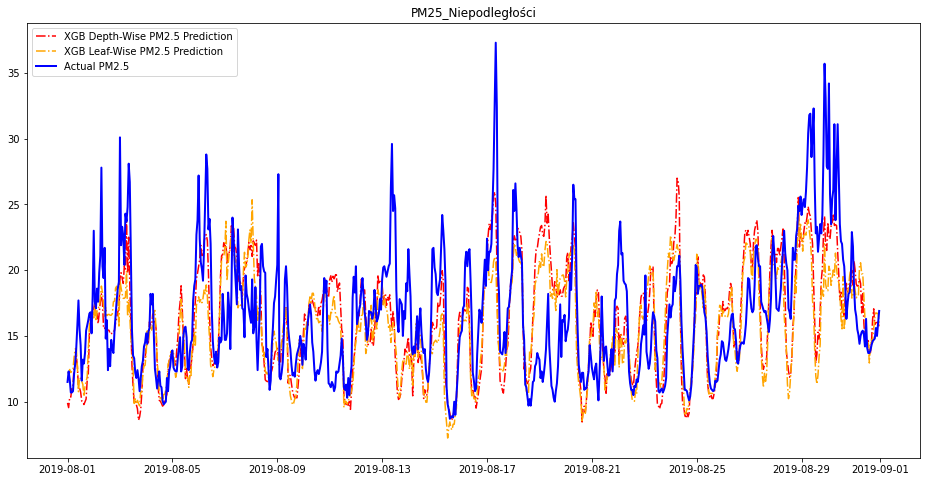

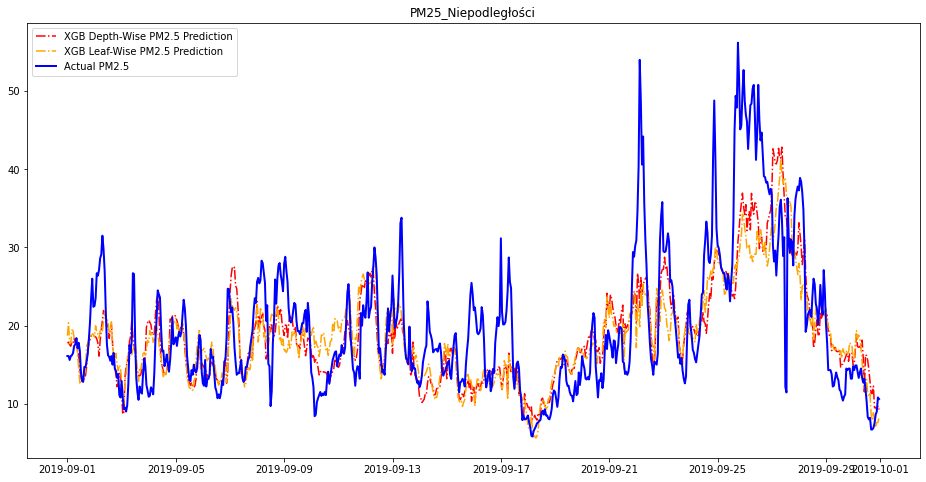

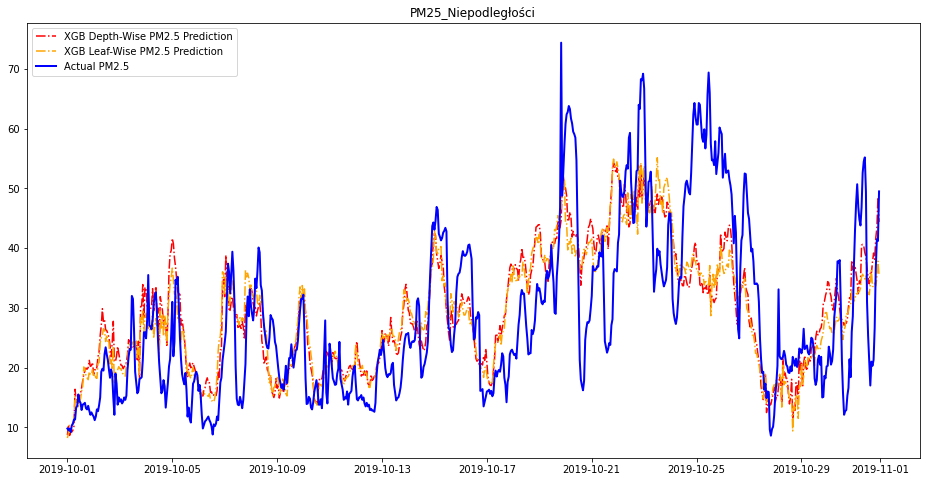

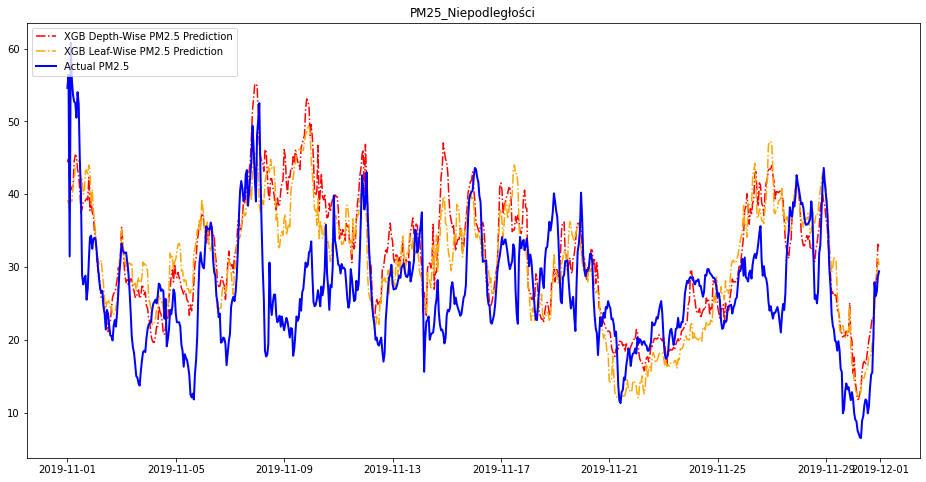

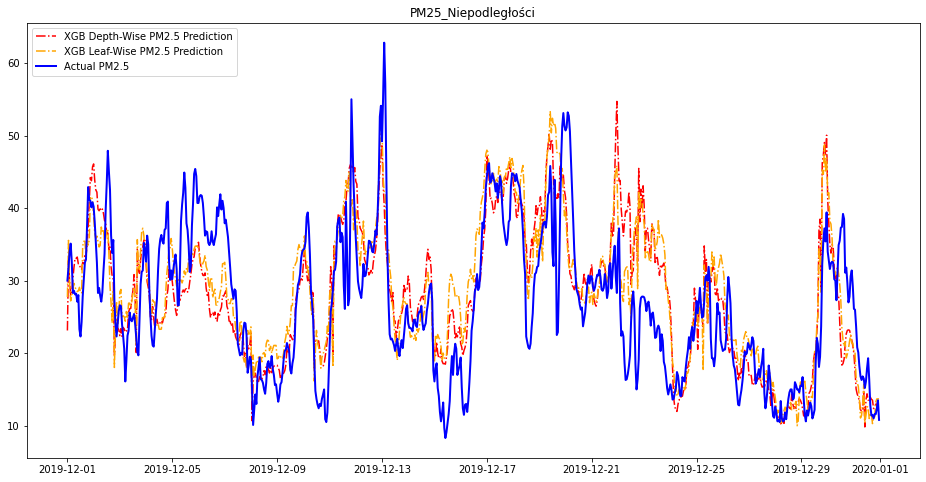

In [ ]:
# compare results for each month in the test dataset
for mth in months:
    test_mask = df_test['month'] == mth
    fig, ax = plt.subplots(figsize=(16,8))
    
    #forecast
    ax.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie_pred_xgb_depth_manual'],
            color='red', linestyle='dashdot', label='XGB Depth-Wise PM2.5 Prediction')
    #forecast
    ax.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie_pred_xgb_leaf_manual'],
            color='orange', linestyle='dashdot', label='XGB Leaf-Wise PM2.5 Prediction') 
    #actual
    ax.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie'],
            color='blue', linewidth=2, label='Actual PM2.5') 
    
    legend = ax.legend(loc='upper left', fontsize='medium')
    plt.title('PM25_Niepodległości')
    plt.show()